<a href="https://colab.research.google.com/github/anbinh-bui/Graph-Neural-Networks-for-Credit-Card-Fraud-Detection/blob/main/GNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torch-geometric scikit-learn

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

In [ ]:
train_transaction = pd.read_csv('/content/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('/content/test_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('/content/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('/content/test_identity.csv', index_col='TransactionID')


In [ ]:
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

train = train.sample(frac=1, random_state=42)
train.reset_index(drop=True, inplace=True)


In [ ]:
y = train.isFraud.values

In [ ]:
train = train.drop('isFraud', axis=1)
test = test.copy()
train = train.fillna(-1)
test = test.fillna(-1)
del train_transaction, train_identity, test_transaction, test_identity

In [ ]:
one_hot_encoded_training_predictors = pd.get_dummies(train)
one_hot_encoded_test_predictors = pd.get_dummies(test)
train, test = one_hot_encoded_training_predictors.align(one_hot_encoded_test_predictors,
                                                                    join='left',
                                                                    axis=1)


In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

#Reduce memory
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to  5.40 Mb (67.4% reduction)
Mem. usage decreased to 13.25 Mb (42.8% reduction)


In [ ]:
# Convert DataFrame columns to numeric types
train = train.apply(pd.to_numeric, errors='coerce')
test = test.apply(pd.to_numeric, errors='coerce')
train = train.fillna(0)
test = test.fillna(0)

# Ensure all columns are numeric
train = train.select_dtypes(include=[np.number])
test = test.select_dtypes(include=[np.number])

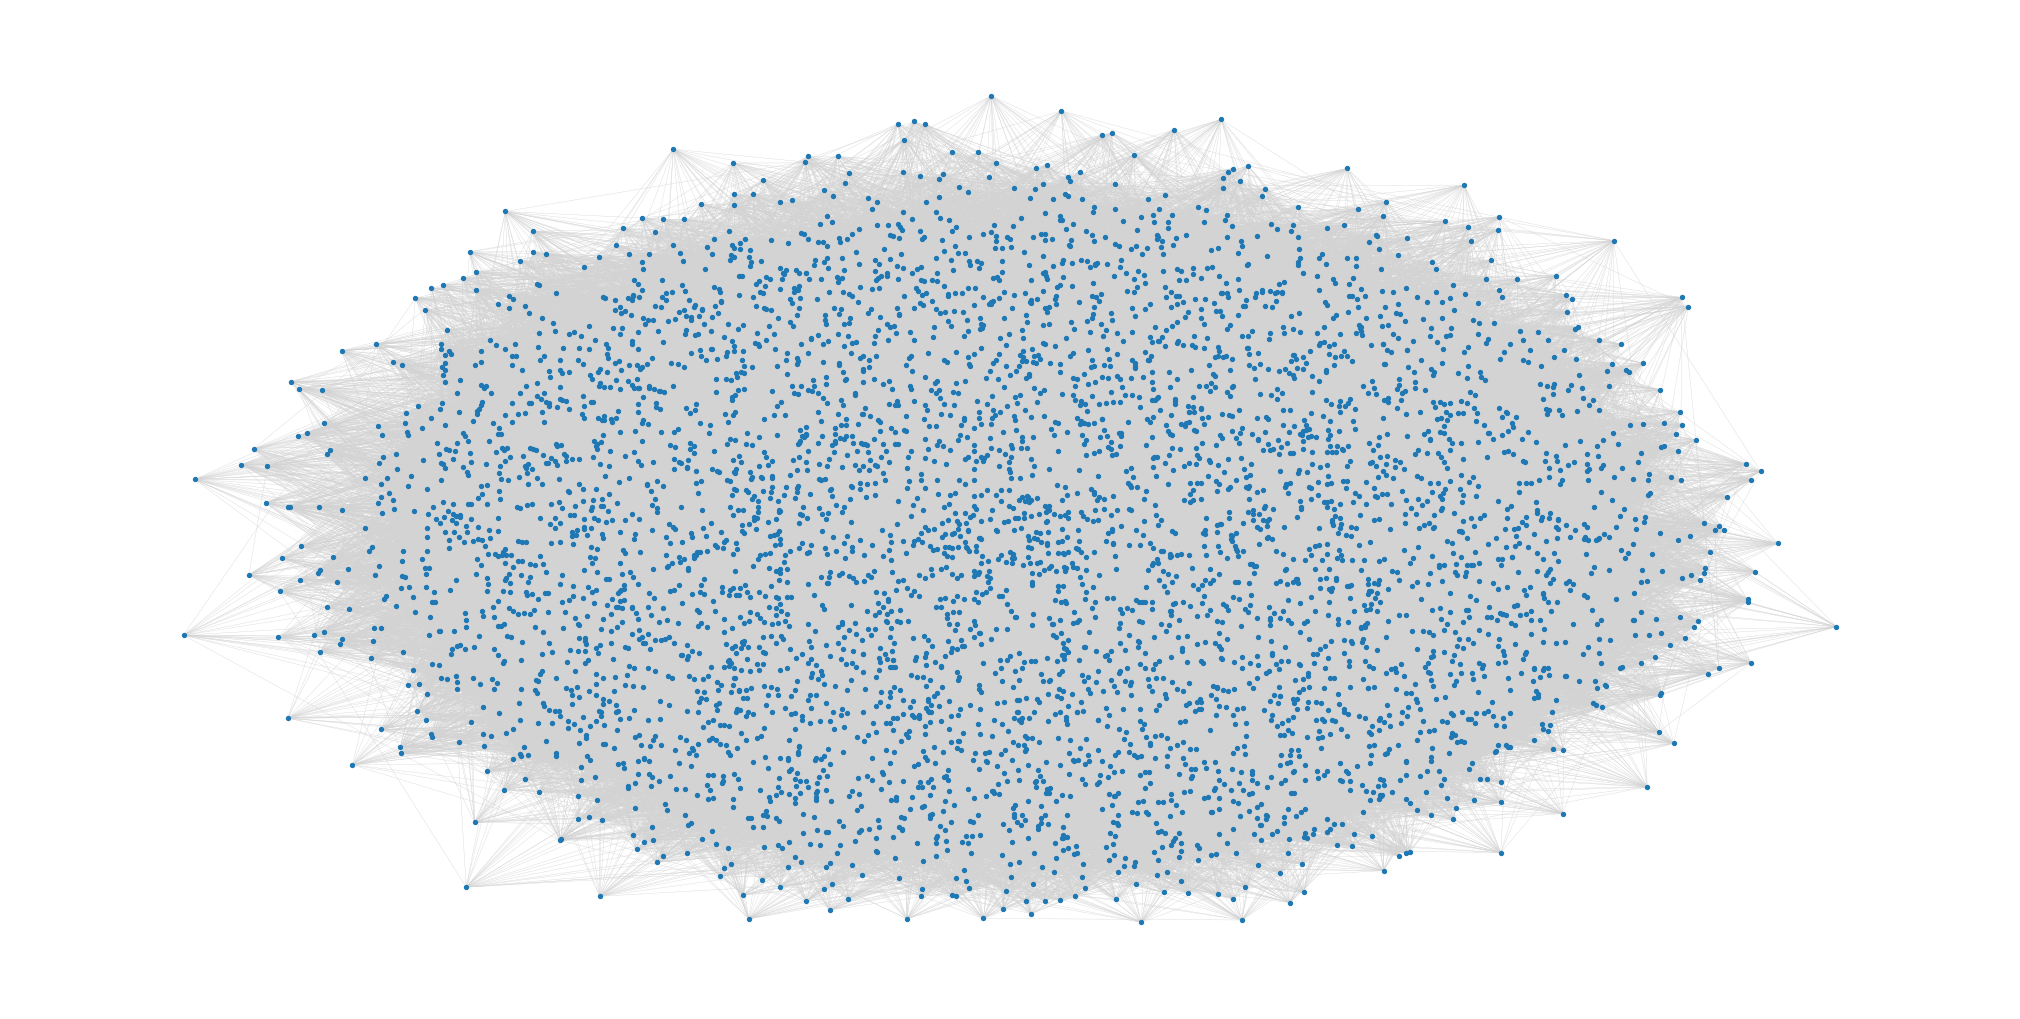

In [ ]:
# Create edge list for the graph
def create_edges(data, threshold=0.9):
    edges = []
    for i in range(data.shape[0]):
        for j in range(i + 1, data.shape[0]):
            if np.random.rand() > threshold:  # Randomly connect nodes
                edges.append((i, j))
    return edges

# Visualize the graph
def visualize_graph(data, edges):
    G = nx.Graph()
    for i in range(data.shape[0]):
        G.add_node(i)
    for edge in edges:
        G.add_edge(edge[0], edge[1])

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(20, 10))
    nx.draw(G, pos, node_size=8, edge_color='lightgrey', width=0.25)
    plt.show()

# Create and visualize edges
edges = create_edges(train, threshold=0.99)
visualize_graph(train, edges)


In [ ]:
# Function to visualize the graph with fraud scores
def visualize_graph_with_fraud_scores(data, edges, fraud_scores):
    G = nx.Graph()
    for i in range(data.shape[0]):
        G.add_node(i)
    for edge in edges:
        G.add_edge(edge[0], edge[1])

    pos = nx.spring_layout(G, seed=42)

    # Normalize fraud scores for color mapping
    norm = plt.Normalize(vmin=min(fraud_scores), vmax=max(fraud_scores))
    cmap = plt.get_cmap('Reds')

    node_colors = [cmap(norm(score)) for score in fraud_scores]

    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, node_size=10, edge_color='lightgrey', width=0.5, node_color=node_colors)
    plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Function to select top k features based on mutual information
def select_top_features(data, labels, k):
    mi_scores = mutual_info_classif(data, labels)
    top_k_indices = np.argsort(mi_scores)[-k:]
    return data.iloc[:, top_k_indices]

# Assuming 'train' DataFrame and 'y' labels are already defined
k = 20  # Number of top features to select
selected_train = select_top_features(train, y, k)

# Create the PyTorch Geometric data object with selected features
data = create_pyg_data(selected_train, y, edges)


In [ ]:
# Create PyTorch Geometric data object
def create_pyg_data(features, labels, edges):
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    x = torch.tensor(features.values, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

# Create data object
data = create_pyg_data(train, y, edges)

GCN

In [ ]:
# GCN Model Definition
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
# Function to create PyTorch Geometric data object
def create_pyg_data(features, labels, edges):
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    x = torch.tensor(features.values, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

# Create data object
data = create_pyg_data(train, y, edges)

In [ ]:
def train_model_and_track_performance(train_data, val_data, model, optimizer, criterion, max_epochs=100):
    train_losses = []
    val_losses = []
    roc_auc_scores = []

    best_epoch = 0
    best_auc = 0
    best_model_state = None

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(train_data)
        loss = criterion(out[train_data.train_mask], train_data.y[train_data.train_mask])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_out = model(val_data)
            val_loss = criterion(val_out[val_data.test_mask], val_data.y[val_data.test_mask])
            val_losses.append(val_loss.item())

            # Calculate ROC AUC score
            preds = val_out[val_data.test_mask].argmax(dim=1).cpu().numpy()
            auc = roc_auc_score(val_data.y.cpu().numpy()[val_data.test_mask.cpu().numpy()], preds)
            roc_auc_scores.append(auc)

            if auc > best_auc:
                best_auc = auc
                best_epoch = epoch
                best_model_state = model.state_dict()

        print(f'Epoch {epoch+1}/{max_epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}, Val AUC: {auc}')

    return train_losses, val_losses, roc_auc_scores, best_model_state, best_epoch, best_auc

In [ ]:
def plot_performance_over_epochs(roc_auc_scores, fold):
    plt.figure(figsize=(10, 5))
    plt.plot(roc_auc_scores, label=f'Fold {fold} Validation ROC AUC')
    plt.xlabel('Epochs')
    plt.ylabel('ROC AUC')
    plt.title(f'Performance over Epochs for Fold {fold}')
    plt.legend()
    plt.show()


Epoch 1/200, Train Loss: 859.1718139648438, Val Loss: 5113.98828125, Val AUC: 0.5009777132610367
Epoch 2/200, Train Loss: 5186.482421875, Val Loss: 514.9139404296875, Val AUC: 0.5
Epoch 3/200, Train Loss: 583.150634765625, Val Loss: 982.5992431640625, Val AUC: 0.5
Epoch 4/200, Train Loss: 1120.929931640625, Val Loss: 1349.4114990234375, Val AUC: 0.5
Epoch 5/200, Train Loss: 1542.6353759765625, Val Loss: 1640.1168212890625, Val AUC: 0.5
Epoch 6/200, Train Loss: 1876.6732177734375, Val Loss: 1866.0048828125, Val AUC: 0.5
Epoch 7/200, Train Loss: 2136.702392578125, Val Loss: 2031.336181640625, Val AUC: 0.5
Epoch 8/200, Train Loss: 2326.979736328125, Val Loss: 2141.42333984375, Val AUC: 0.5
Epoch 9/200, Train Loss: 2454.113037109375, Val Loss: 2201.5693359375, Val AUC: 0.5
Epoch 10/200, Train Loss: 2523.6435546875, Val Loss: 2215.5615234375, Val AUC: 0.5
Epoch 11/200, Train Loss: 2538.71337890625, Val Loss: 2188.60498046875, Val AUC: 0.5
Epoch 12/200, Train Loss: 2506.20068359375, Val Loss

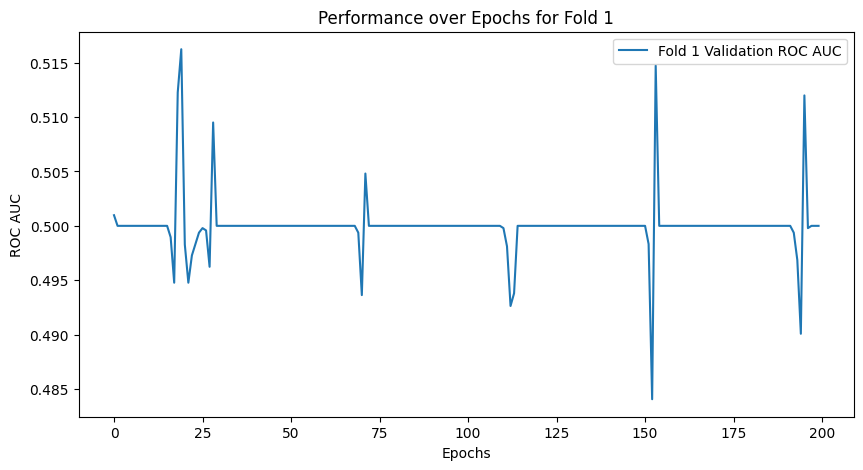

Epoch 1/200, Train Loss: 428.10992431640625, Val Loss: 3312.78173828125, Val AUC: 0.5048299034019319
Epoch 2/200, Train Loss: 3269.956787109375, Val Loss: 321.9413146972656, Val AUC: 0.5
Epoch 3/200, Train Loss: 282.60443115234375, Val Loss: 627.0769653320312, Val AUC: 0.5
Epoch 4/200, Train Loss: 545.4598999023438, Val Loss: 858.647705078125, Val AUC: 0.5
Epoch 5/200, Train Loss: 744.7632446289062, Val Loss: 1030.2510986328125, Val AUC: 0.5
Epoch 6/200, Train Loss: 892.9298095703125, Val Loss: 1153.5206298828125, Val AUC: 0.5
Epoch 7/200, Train Loss: 999.5985107421875, Val Loss: 1237.7738037109375, Val AUC: 0.5
Epoch 8/200, Train Loss: 1072.5811767578125, Val Loss: 1280.256103515625, Val AUC: 0.5
Epoch 9/200, Train Loss: 1109.34912109375, Val Loss: 1286.8175048828125, Val AUC: 0.5
Epoch 10/200, Train Loss: 1115.346435546875, Val Loss: 1258.27783203125, Val AUC: 0.5
Epoch 11/200, Train Loss: 1090.988525390625, Val Loss: 1197.48046875, Val AUC: 0.5
Epoch 12/200, Train Loss: 1038.6800537

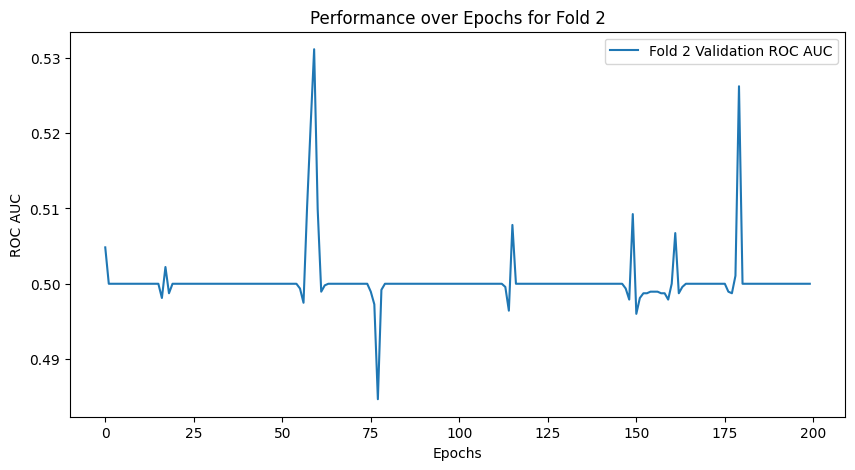

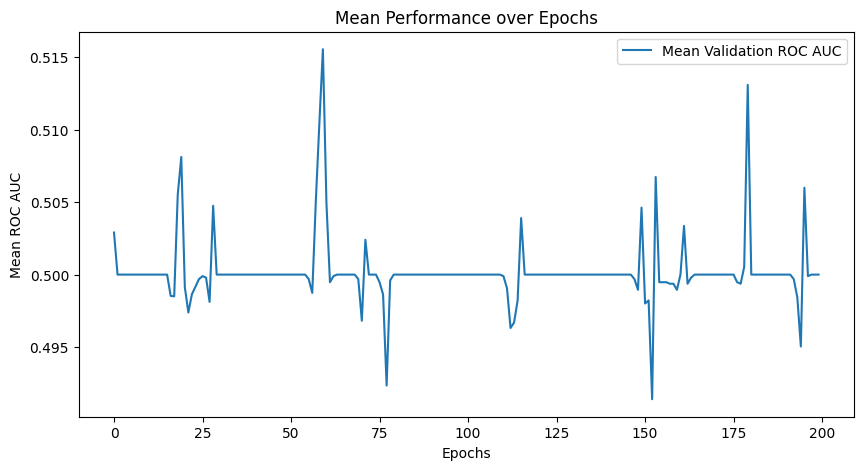

Mean AUC-ROC Scores over Epochs: [0.50290381 0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.49853201 0.49849647
 0.50550527 0.50812271 0.4991397  0.49738494 0.49864017 0.49916318
 0.49968619 0.4998954  0.49979079 0.49811715 0.50475408 0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.49968501 0.49874003 0.50505076 0.51043281 0.5155596
 0.50494576 0.49947501 0.499895   0.5        0.5        0.5
 0.5        0.5        0.5        0.49968619 0.49681496 0.50240586
 0.5        0.5        0.5        0.49947501 0.49863503 0.49234058
 0.49959811 0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5       

In [ ]:
kf = KFold(n_splits=2, shuffle=True, random_state=42)
all_roc_auc_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(data.x), 1):
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    train_mask[train_index] = True
    test_mask[test_index] = True

    train_data = Data(x=data.x, edge_index=data.edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)
    test_data = Data(x=data.x, edge_index=data.edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)

    model = GCN(input_dim=data.x.shape[1], hidden_dim=64, output_dim=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses, val_losses, roc_auc_scores, best_model_state, best_epoch, best_auc = train_model_and_track_performance(train_data, test_data, model, optimizer, criterion, max_epochs=200)
    all_roc_auc_scores.append(roc_auc_scores)

    plot_performance_over_epochs(roc_auc_scores, fold)

# Calculate and plot the mean AUC-ROC score across folds for each epoch
mean_auc_scores = np.mean(all_roc_auc_scores, axis=0)
plt.figure(figsize=(10, 5))
plt.plot(mean_auc_scores, label='Mean Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Mean ROC AUC')
plt.title('Mean Performance over Epochs')
plt.legend()
plt.show()

print(f'Mean AUC-ROC Scores over Epochs: {mean_auc_scores}')
print(f'Best Epoch: {np.argmax(mean_auc_scores) + 1}, Best Mean AUC-ROC Score: {np.max(mean_auc_scores)}')

# Load the best model state
model.load_state_dict(best_model_state)

# Collect fraud scores for the test set at the best epoch
model.eval()
with torch.no_grad():
    out = model(test_data)
    out_probs = F.softmax(out, dim=1)  # Apply softmax to get probabilities
    fraud_scores = out_probs[:, 1].cpu().numpy()  # Get the probability for the fraudulent class

# Print min and max fraud scores for debugging
print(f'Min fraud score: {min(fraud_scores)}')
print(f'Max fraud score: {max(fraud_scores)}')


In [ ]:
def visualize_graph_with_fraud_scores(data, edges, fraud_scores):
    G = nx.Graph()
    for i in range(data.x.shape[0]):
        G.add_node(i)
    for edge in edges:
        G.add_edge(edge[0], edge[1])

    pos = nx.spring_layout(G, seed=42)

    # Custom colormap from blue to red
    cmap = mcolors.LinearSegmentedColormap.from_list("blue_red", ["blue", "red"])
    norm = plt.Normalize(vmin=0, vmax=1)

    node_colors = [cmap(norm(score)) for score in fraud_scores]

    plt.figure(figsize=(20, 10))
    nx.draw(G, pos, node_size=8, edge_color='lightgrey', width=0.25, node_color=node_colors)
    plt.show()

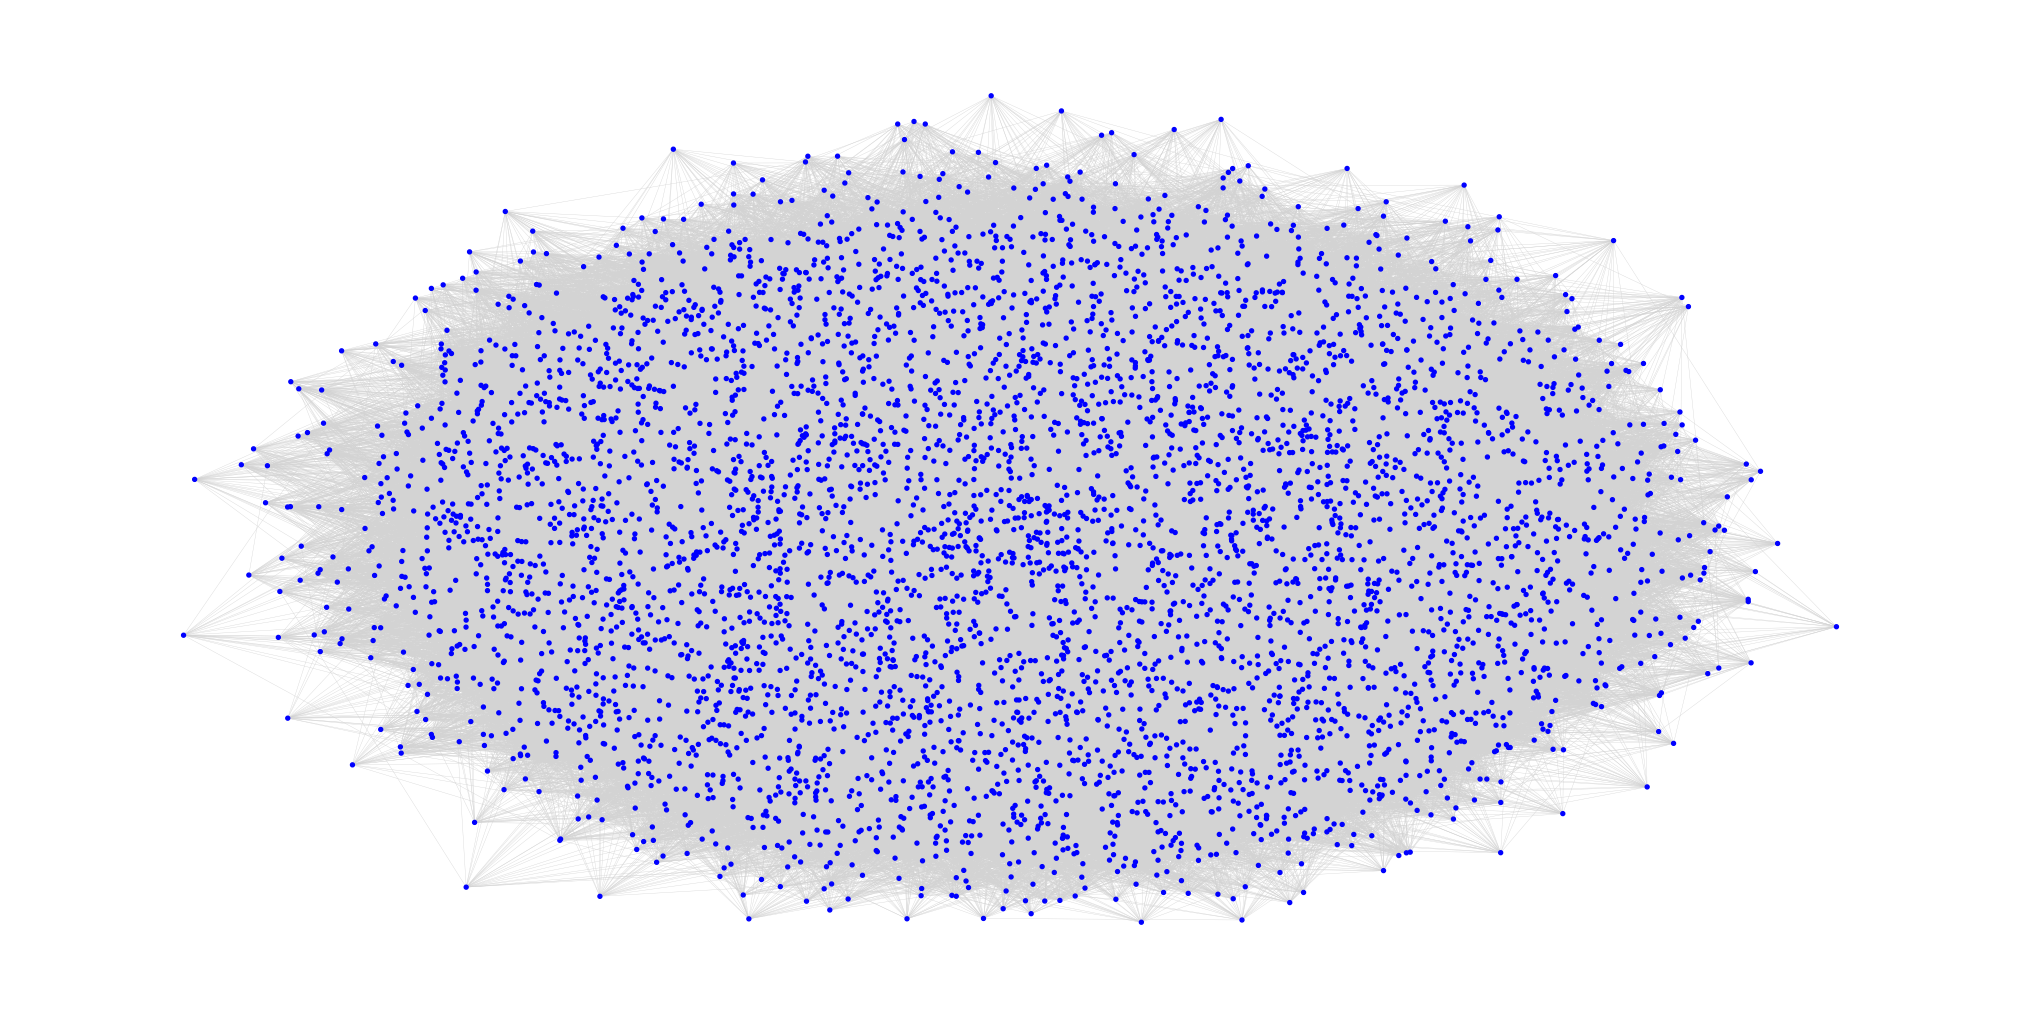

In [ ]:
visualize_graph_with_fraud_scores(test_data, edges, fraud_scores)


GraphSAGE

In [ ]:
from torch_geometric.nn import SAGEConv

# Define the GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
# Function to train and track performance for GraphSAGE
def train_graphsage_and_track_performance(train_data, val_data, model, optimizer, criterion, max_epochs=200):
    train_losses = []
    val_losses = []
    roc_auc_scores = []

    best_epoch = 0
    best_auc = 0
    best_model_state = None

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(train_data)
        loss = criterion(out[train_data.train_mask], train_data.y[train_data.train_mask])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_out = model(val_data)
            val_loss = criterion(val_out[val_data.test_mask], val_data.y[val_data.test_mask])
            val_losses.append(val_loss.item())

            # Calculate ROC AUC score
            preds = val_out[val_data.test_mask].argmax(dim=1).cpu().numpy()
            auc = roc_auc_score(val_data.y.cpu().numpy()[val_data.test_mask.cpu().numpy()], preds)
            roc_auc_scores.append(auc)

            if auc > best_auc:
                best_auc = auc
                best_epoch = epoch
                best_model_state = model.state_dict()

        print(f'Epoch {epoch+1}/{max_epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}, Val AUC: {auc}')

    return train_losses, val_losses, roc_auc_scores, best_model_state, best_epoch, best_auc


Epoch 1/200, Train Loss: 13289.697265625, Val Loss: 201.23504638671875, Val AUC: 0.49011446409989595
Epoch 2/200, Train Loss: 287.8419494628906, Val Loss: 431.1986999511719, Val AUC: 0.5
Epoch 3/200, Train Loss: 646.6197509765625, Val Loss: 574.1556396484375, Val AUC: 0.5
Epoch 4/200, Train Loss: 866.3187866210938, Val Loss: 662.5686645507812, Val AUC: 0.5
Epoch 5/200, Train Loss: 1002.784423828125, Val Loss: 712.6415405273438, Val AUC: 0.5
Epoch 6/200, Train Loss: 1079.4400634765625, Val Loss: 733.4827270507812, Val AUC: 0.5
Epoch 7/200, Train Loss: 1108.39013671875, Val Loss: 730.6219482421875, Val AUC: 0.5
Epoch 8/200, Train Loss: 1099.3017578125, Val Loss: 709.6570434570312, Val AUC: 0.5
Epoch 9/200, Train Loss: 1060.9293212890625, Val Loss: 673.1663208007812, Val AUC: 0.5
Epoch 10/200, Train Loss: 997.7188110351562, Val Loss: 618.3623657226562, Val AUC: 0.5
Epoch 11/200, Train Loss: 906.2523803710938, Val Loss: 546.9242553710938, Val AUC: 0.4994797086368366
Epoch 12/200, Train Los

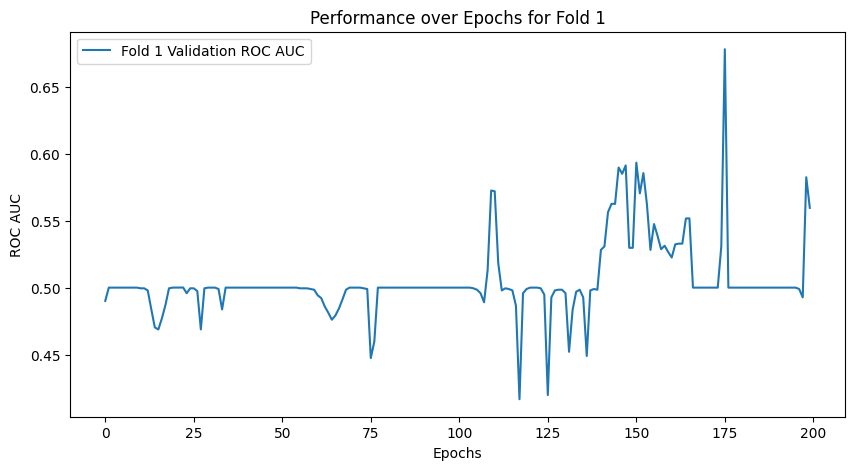

Epoch 1/200, Train Loss: 2989.40869140625, Val Loss: 401.27239990234375, Val AUC: 0.5
Epoch 2/200, Train Loss: 346.1948547363281, Val Loss: 690.0015869140625, Val AUC: 0.5
Epoch 3/200, Train Loss: 596.4537963867188, Val Loss: 871.0734252929688, Val AUC: 0.5
Epoch 4/200, Train Loss: 752.8915405273438, Val Loss: 982.5404052734375, Val AUC: 0.5
Epoch 5/200, Train Loss: 846.7897338867188, Val Loss: 1041.8184814453125, Val AUC: 0.5
Epoch 6/200, Train Loss: 895.2693481445312, Val Loss: 1058.8082275390625, Val AUC: 0.5
Epoch 7/200, Train Loss: 906.0076293945312, Val Loss: 1029.3216552734375, Val AUC: 0.5
Epoch 8/200, Train Loss: 878.0237426757812, Val Loss: 952.2489624023438, Val AUC: 0.5
Epoch 9/200, Train Loss: 809.3035888671875, Val Loss: 833.4946899414062, Val AUC: 0.4994747899159664
Epoch 10/200, Train Loss: 707.6897583007812, Val Loss: 706.5840454101562, Val AUC: 0.5176820728291317
Epoch 11/200, Train Loss: 628.051025390625, Val Loss: 585.3182373046875, Val AUC: 0.5155812324929973
Epoch

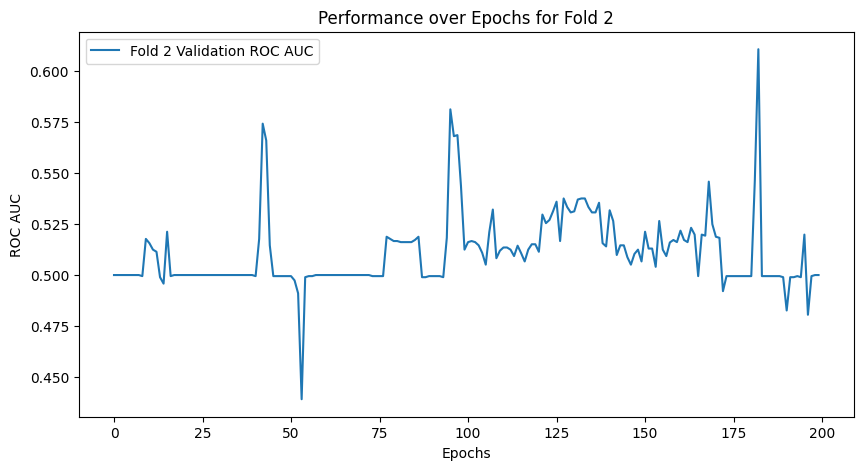

Epoch 1/200, Train Loss: 2492.18701171875, Val Loss: 285.1017761230469, Val AUC: 0.5
Epoch 2/200, Train Loss: 309.2630920410156, Val Loss: 476.87237548828125, Val AUC: 0.5
Epoch 3/200, Train Loss: 525.6586303710938, Val Loss: 604.040283203125, Val AUC: 0.5
Epoch 4/200, Train Loss: 670.2567749023438, Val Loss: 689.8080444335938, Val AUC: 0.5
Epoch 5/200, Train Loss: 768.2001342773438, Val Loss: 733.6785278320312, Val AUC: 0.5
Epoch 6/200, Train Loss: 823.0802001953125, Val Loss: 748.5717163085938, Val AUC: 0.5
Epoch 7/200, Train Loss: 844.2879028320312, Val Loss: 734.275634765625, Val AUC: 0.5
Epoch 8/200, Train Loss: 831.8953857421875, Val Loss: 689.7098999023438, Val AUC: 0.5
Epoch 9/200, Train Loss: 786.33740234375, Val Loss: 615.9573974609375, Val AUC: 0.5
Epoch 10/200, Train Loss: 708.6136474609375, Val Loss: 513.3873291015625, Val AUC: 0.5
Epoch 11/200, Train Loss: 598.9193725585938, Val Loss: 392.3122253417969, Val AUC: 0.49895506792058514
Epoch 12/200, Train Loss: 460.5539855957

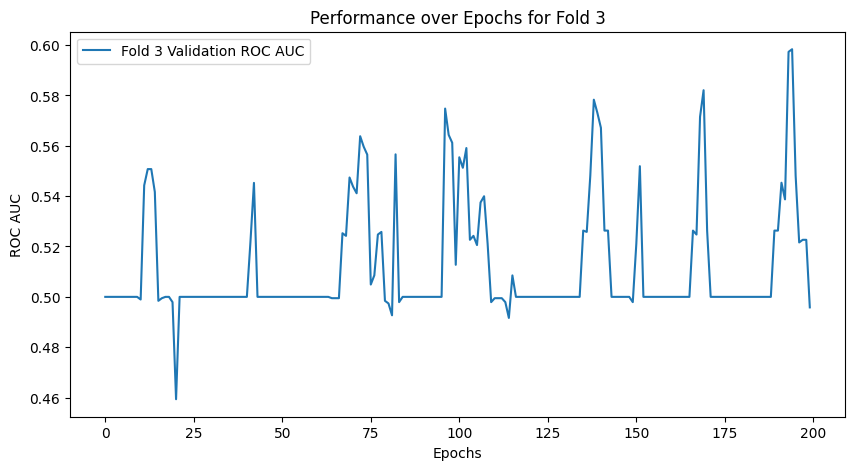

Epoch 1/200, Train Loss: 4414.51025390625, Val Loss: 705.156494140625, Val AUC: 0.5
Epoch 2/200, Train Loss: 498.72125244140625, Val Loss: 1271.6446533203125, Val AUC: 0.5
Epoch 3/200, Train Loss: 897.5525512695312, Val Loss: 1665.734619140625, Val AUC: 0.5
Epoch 4/200, Train Loss: 1174.7701416015625, Val Loss: 1945.61279296875, Val AUC: 0.5
Epoch 5/200, Train Loss: 1373.0552978515625, Val Loss: 2147.65283203125, Val AUC: 0.5
Epoch 6/200, Train Loss: 1515.619140625, Val Loss: 2285.81591796875, Val AUC: 0.5
Epoch 7/200, Train Loss: 1612.850341796875, Val Loss: 2369.843505859375, Val AUC: 0.5
Epoch 8/200, Train Loss: 1671.877197265625, Val Loss: 2404.7451171875, Val AUC: 0.5
Epoch 9/200, Train Loss: 1696.52294921875, Val Loss: 2389.94970703125, Val AUC: 0.5
Epoch 10/200, Train Loss: 1686.178955078125, Val Loss: 2326.455322265625, Val AUC: 0.5
Epoch 11/200, Train Loss: 1642.290283203125, Val Loss: 2217.83544921875, Val AUC: 0.5
Epoch 12/200, Train Loss: 1566.9940185546875, Val Loss: 2064.

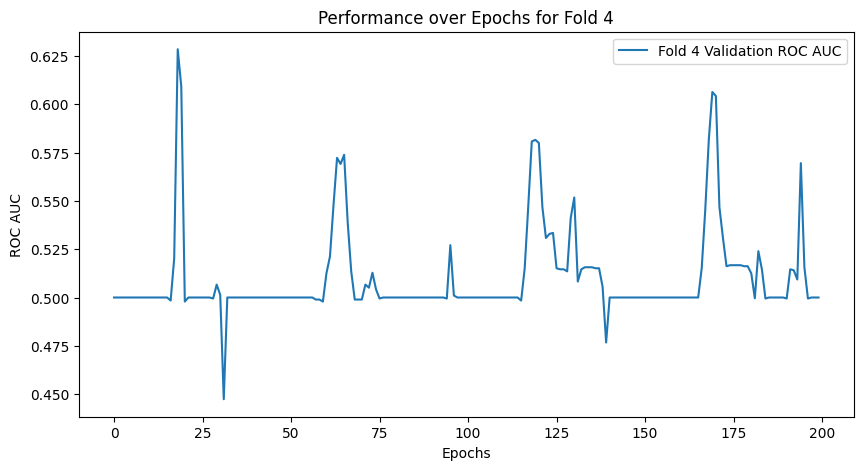

Epoch 1/200, Train Loss: 3729.9326171875, Val Loss: 454.2629699707031, Val AUC: 0.5
Epoch 2/200, Train Loss: 483.0157470703125, Val Loss: 769.1494750976562, Val AUC: 0.5
Epoch 3/200, Train Loss: 816.2830810546875, Val Loss: 967.1983032226562, Val AUC: 0.5
Epoch 4/200, Train Loss: 1025.9251708984375, Val Loss: 1094.6502685546875, Val AUC: 0.5
Epoch 5/200, Train Loss: 1164.4429931640625, Val Loss: 1173.54443359375, Val AUC: 0.5
Epoch 6/200, Train Loss: 1250.115966796875, Val Loss: 1211.80615234375, Val AUC: 0.5
Epoch 7/200, Train Loss: 1293.7554931640625, Val Loss: 1212.3480224609375, Val AUC: 0.5
Epoch 8/200, Train Loss: 1297.68115234375, Val Loss: 1178.7225341796875, Val AUC: 0.5
Epoch 9/200, Train Loss: 1264.6614990234375, Val Loss: 1113.4072265625, Val AUC: 0.5
Epoch 10/200, Train Loss: 1196.900390625, Val Loss: 1018.1708984375, Val AUC: 0.5
Epoch 11/200, Train Loss: 1097.442626953125, Val Loss: 895.92724609375, Val AUC: 0.5
Epoch 12/200, Train Loss: 969.1785888671875, Val Loss: 747.

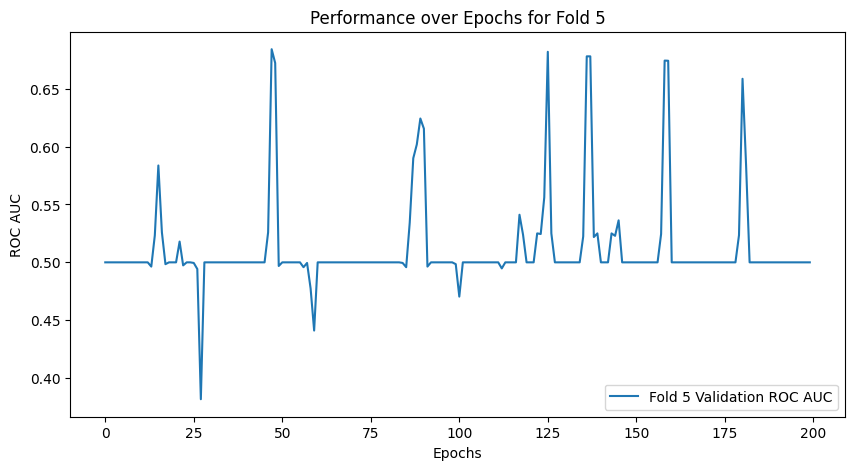

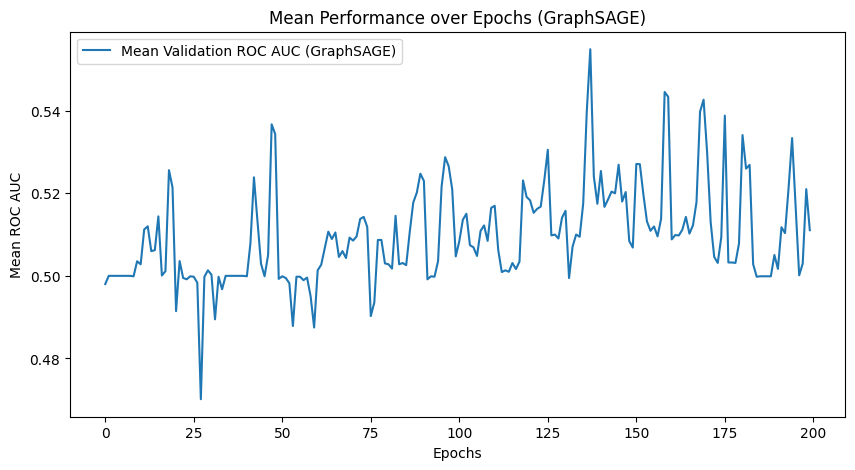

Mean AUC-ROC Scores over Epochs (GraphSAGE): [0.49802289 0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.49989496 0.50353641 0.5028032  0.51123636
 0.51200652 0.50597797 0.50621999 0.51440747 0.50007802 0.50112684
 0.52559034 0.52141989 0.4914487  0.50358639 0.49949031 0.49916753
 0.49989594 0.49979123 0.49832788 0.4701247  0.49979023 0.50133411
 0.50027703 0.48947292 0.49979188 0.49674644 0.5        0.5
 0.5        0.5        0.5        0.5        0.49989496 0.50785913
 0.52386334 0.51316527 0.50290616 0.49989496 0.5050782  0.53670124
 0.53431904 0.49926669 0.49989496 0.49947479 0.49821429 0.48785014
 0.49978992 0.4997909  0.4989532  0.49957981 0.49507785 0.48748489
 0.50135226 0.50269297 0.5067552  0.51070677 0.50892745 0.51050317
 0.50458159 0.5059935  0.50432159 0.50926997 0.50853851 0.50956158
 0.51377616 0.51427664 0.51183606 0.4902583  0.49355817 0.50869618
 0.50869508 0.50301285 0.50280386 0.50175838 0.51453955 0.50280332
 0.50311658 0.50259368 0.510605

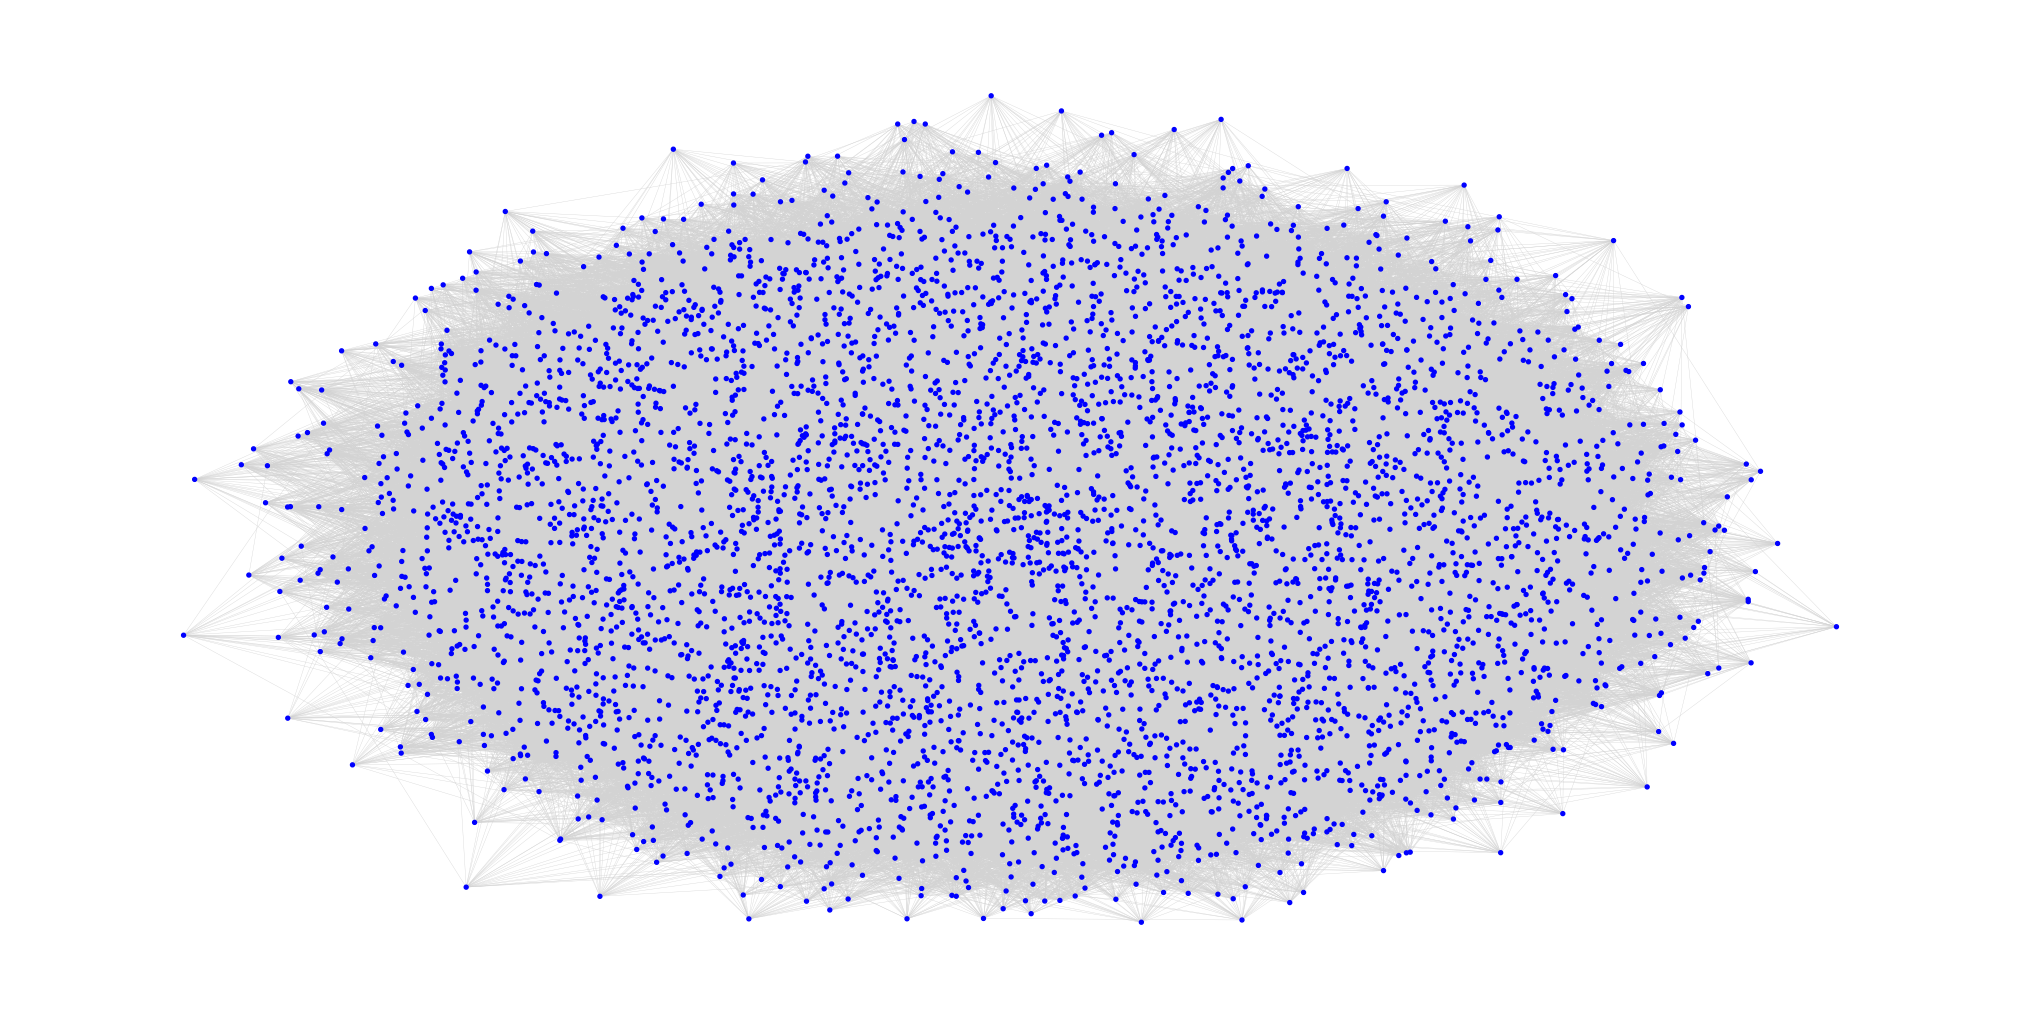

In [ ]:
# K-Fold Cross-Validation for GraphSAGE
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_graphsage_roc_auc_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(data.x), 1):
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    train_mask[train_index] = True
    test_mask[test_index] = True

    train_data = Data(x=data.x, edge_index=data.edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)
    test_data = Data(x=data.x, edge_index=data.edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)

    graphsage_model = GraphSAGE(input_dim=data.x.shape[1], hidden_dim=64, output_dim=2)
    optimizer = torch.optim.Adam(graphsage_model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses, val_losses, roc_auc_scores, best_model_state, best_epoch, best_auc = train_graphsage_and_track_performance(train_data, test_data, graphsage_model, optimizer, criterion, max_epochs=200)
    all_graphsage_roc_auc_scores.append(roc_auc_scores)

    plot_performance_over_epochs(roc_auc_scores, fold)

# Calculate and plot the mean AUC-ROC score across folds for each epoch
mean_graphsage_auc_scores = np.mean(all_graphsage_roc_auc_scores, axis=0)
plt.figure(figsize=(10, 5))
plt.plot(mean_graphsage_auc_scores, label='Mean Validation ROC AUC (GraphSAGE)')
plt.xlabel('Epochs')
plt.ylabel('Mean ROC AUC')
plt.title('Mean Performance over Epochs (GraphSAGE)')
plt.legend()
plt.show()

print(f'Mean AUC-ROC Scores over Epochs (GraphSAGE): {mean_graphsage_auc_scores}')
print(f'Best Epoch (GraphSAGE): {np.argmax(mean_graphsage_auc_scores) + 1}, Best Mean AUC-ROC Score (GraphSAGE): {np.max(mean_graphsage_auc_scores)}')

# Load the best model state for GraphSAGE
graphsage_model.load_state_dict(best_model_state)

# Collect fraud scores for the test set at the best epoch
graphsage_model.eval()
with torch.no_grad():
    out = graphsage_model(test_data)
    out_probs = F.softmax(out, dim=1)  # Apply softmax to get probabilities
    fraud_scores = out_probs[:, 1].cpu().numpy()  # Get the probability for the fraudulent class

# Print min and max fraud scores for debugging
print(f'Min fraud score (GraphSAGE): {min(fraud_scores)}')
print(f'Max fraud score (GraphSAGE): {max(fraud_scores)}')

# Visualize the graph with fraud scores using the same visualization function
visualize_graph_with_fraud_scores(test_data, edges, fraud_scores)


GAT

In [ ]:
from torch_geometric.nn import GATConv

# Define the GAT model
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=1):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
# Function to train and track performance for GAT
def train_gat_and_track_performance(train_data, val_data, model, optimizer, criterion, max_epochs=200):
    train_losses = []
    val_losses = []
    roc_auc_scores = []

    best_epoch = 0
    best_auc = 0
    best_model_state = None

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(train_data)
        loss = criterion(out[train_data.train_mask], train_data.y[train_data.train_mask])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_out = model(val_data)
            val_loss = criterion(val_out[val_data.test_mask], val_data.y[val_data.test_mask])
            val_losses.append(val_loss.item())

            # Calculate ROC AUC score
            preds = val_out[val_data.test_mask].argmax(dim=1).cpu().numpy()
            auc = roc_auc_score(val_data.y.cpu().numpy()[val_data.test_mask.cpu().numpy()], preds)
            roc_auc_scores.append(auc)

            if auc > best_auc:
                best_auc = auc
                best_epoch = epoch
                best_model_state = model.state_dict()

        print(f'Epoch {epoch+1}/{max_epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}, Val AUC: {auc}')

    return train_losses, val_losses, roc_auc_scores, best_model_state, best_epoch, best_auc


Epoch 1/200, Train Loss: 497.0855712890625, Val Loss: 825.3439331054688, Val AUC: 0.5
Epoch 2/200, Train Loss: 1301.644775390625, Val Loss: 906.8123168945312, Val AUC: 0.495837669094693
Epoch 3/200, Train Loss: 1741.8380126953125, Val Loss: 4100.19189453125, Val AUC: 0.5690600069372181
Epoch 4/200, Train Loss: 4234.21630859375, Val Loss: 617.2886352539062, Val AUC: 0.5
Epoch 5/200, Train Loss: 920.164794921875, Val Loss: 968.859130859375, Val AUC: 0.5
Epoch 6/200, Train Loss: 1431.2025146484375, Val Loss: 1238.59619140625, Val AUC: 0.5
Epoch 7/200, Train Loss: 1856.7132568359375, Val Loss: 1512.4776611328125, Val AUC: 0.5
Epoch 8/200, Train Loss: 2229.37646484375, Val Loss: 1634.6456298828125, Val AUC: 0.5
Epoch 9/200, Train Loss: 2491.667724609375, Val Loss: 1724.0548095703125, Val AUC: 0.5
Epoch 10/200, Train Loss: 2732.0302734375, Val Loss: 1913.627685546875, Val AUC: 0.5
Epoch 11/200, Train Loss: 2855.5224609375, Val Loss: 1914.7784423828125, Val AUC: 0.5
Epoch 12/200, Train Loss: 

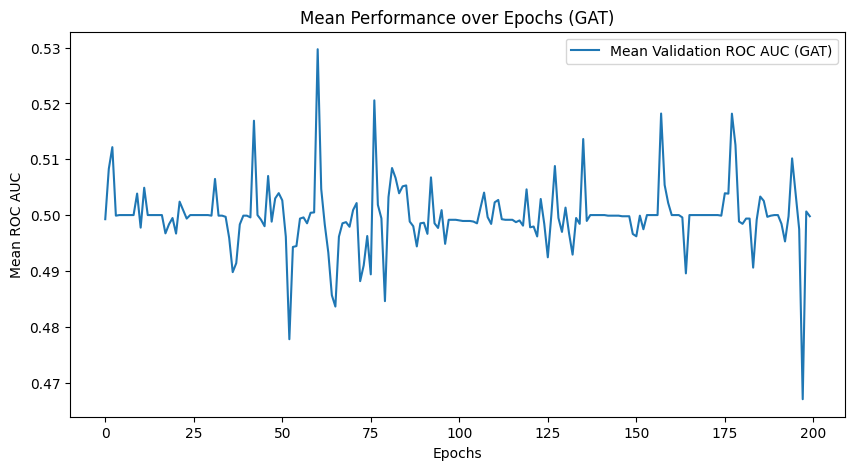

Mean AUC-ROC Scores over Epochs (GAT): [0.49926104 0.50826944 0.51216634 0.49989496 0.5        0.5
 0.5        0.5        0.5        0.50384817 0.49774869 0.50489529
 0.5        0.5        0.5        0.5        0.5        0.49672304
 0.49834876 0.49947146 0.49669095 0.50240417 0.50086692 0.49937304
 0.5        0.5        0.5        0.5        0.5        0.5
 0.49989594 0.50647242 0.49989594 0.49989594 0.49968652 0.49592277
 0.48977719 0.49138743 0.49832461 0.49989529 0.49989594 0.49958377
 0.51689906 0.5        0.49915966 0.4980042  0.50700213 0.49882243
 0.50298676 0.50393014 0.50263412 0.49612452 0.47776125 0.49428984
 0.49444894 0.49937041 0.49957983 0.49852342 0.50041115 0.50047837
 0.52970636 0.50467998 0.49831396 0.49328909 0.48564838 0.48361136
 0.49613204 0.49852668 0.4987348  0.49790233 0.50089758 0.50215151
 0.48816477 0.49099299 0.49624789 0.48938103 0.52054844 0.50182986
 0.49941717 0.48458134 0.50321954 0.50842765 0.50665111 0.50390127
 0.50515054 0.50531093 0.49883721 0.4

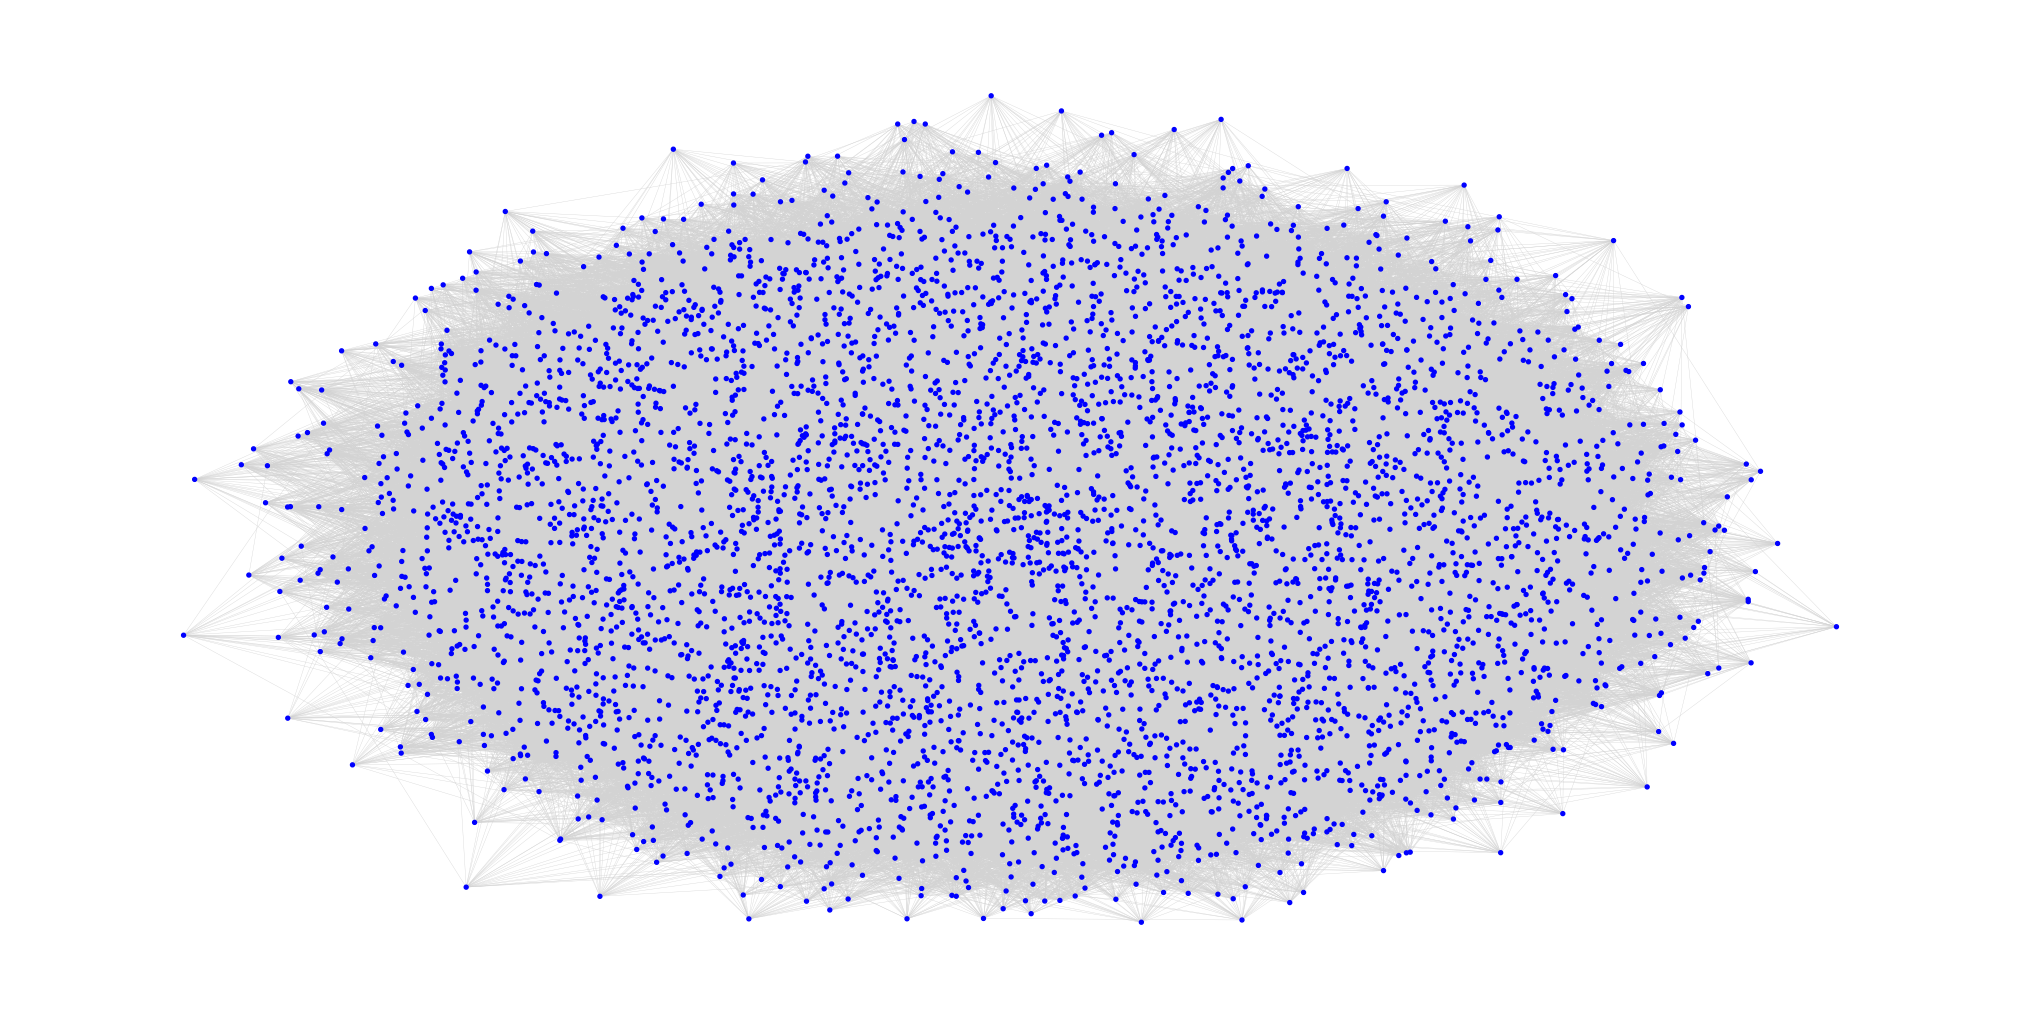

In [ ]:
# K-Fold Cross-Validation for GAT
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_gat_roc_auc_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(data.x), 1):
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    train_mask[train_index] = True
    test_mask[test_index] = True

    train_data = Data(x=data.x, edge_index=data.edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)
    test_data = Data(x=data.x, edge_index=data.edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)

    gat_model = GAT(input_dim=data.x.shape[1], hidden_dim=64, output_dim=2, heads=4)
    optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses, val_losses, roc_auc_scores, best_model_state, best_epoch, best_auc = train_gat_and_track_performance(train_data, test_data, gat_model, optimizer, criterion, max_epochs=200)
    all_gat_roc_auc_scores.append(roc_auc_scores)

# Calculate and plot the mean AUC-ROC score across folds for each epoch
mean_gat_auc_scores = np.mean(all_gat_roc_auc_scores, axis=0)
plt.figure(figsize=(10, 5))
plt.plot(mean_gat_auc_scores, label='Mean Validation ROC AUC (GAT)')
plt.xlabel('Epochs')
plt.ylabel('Mean ROC AUC')
plt.title('Mean Performance over Epochs (GAT)')
plt.legend()
plt.show()

print(f'Mean AUC-ROC Scores over Epochs (GAT): {mean_gat_auc_scores}')
print(f'Best Epoch (GAT): {np.argmax(mean_gat_auc_scores) + 1}, Best Mean AUC-ROC Score (GAT): {np.max(mean_gat_auc_scores)}')

# Load the best model state for GAT
gat_model.load_state_dict(best_model_state)

# Collect fraud scores for the test set at the best epoch
gat_model.eval()
with torch.no_grad():
    out = gat_model(test_data)
    out_probs = F.softmax(out, dim=1)  # Apply softmax to get probabilities
    fraud_scores = out_probs[:, 1].cpu().numpy()  # Get the probability for the fraudulent class

# Print min and max fraud scores for debugging
print(f'Min fraud score (GAT): {min(fraud_scores)}')
print(f'Max fraud score (GAT): {max(fraud_scores)}')

# Visualize the graph with fraud scores using the same visualization function
visualize_graph_with_fraud_scores(test_data, edges, fraud_scores)
